In [1]:
'''
CGMPortfolio model with habit formation

USing HARK.ConsumptionSaving.ConsPortfolioModel as the template and 
studying how habit states change the consumption and the share portfolio

Reference: 
Francisco Gomes, Alexander Michaelides,
Portfolio choice with internal habit formation: a life-cycle model with uninsurable labor income risk,
Review of Economic Dynamics,
Volume 6, Issue 4,
2003,
Pages 729-766,
ISSN 1094-2025,
'''
from HARK.ConsumptionSaving.ConsPortfolioModel import PortfolioConsumerType, init_portfolio
from HARK.ConsumptionSaving.ConsIndShockModel import init_lifecycle
from HARK.utilities import plotFuncs
from copy import copy
from time import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
# If the ipython process contains 'terminal' assume not in a notebook
def in_ipynb():
    try:
        if 'terminal' in str(type(get_ipython())):
            return False
        else:
            return True
    except NameError:
        return False
    
# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline')
else:
    get_ipython().run_line_magic('matplotlib', 'auto')


In [2]:
# Set up the parameters in the paper
# Relative risk aversion
CRRA = 2
# Discount factor
DiscFac = 0.95

time_params = {'Age_born': 20, 'Age_retire': 65, 'Age_death': 100}
t_start = time_params['Age_born']
t_ret   = time_params['Age_retire'] # We are currently interpreting this as the last period of work
t_end   = time_params['Age_death']

# Survival probabilities from the author's Fortran code
n = 80
survprob = np.zeros(n+1)
survprob[0] = 0.99854
survprob[1] = 0.99845
survprob[2] = 0.99839
survprob[3] = 0.99833
survprob[4] = 0.9983
survprob[5] = 0.99827
survprob[6] = 0.99826
survprob[7] = 0.99824
survprob[8] = 0.9982
survprob[9] = 0.99813
survprob[10] = 0.99804
survprob[11] = 0.99795
survprob[12] = 0.99785
survprob[13] = 0.99776
survprob[14] = 0.99766
survprob[15] = 0.99755
survprob[16] = 0.99743
survprob[17] = 0.9973
survprob[18] = 0.99718
survprob[19] = 0.99707
survprob[20] = 0.99696
survprob[21] = 0.99685
survprob[22] = 0.99672
survprob[23] = 0.99656
survprob[24] = 0.99635
survprob[25] = 0.9961
survprob[26] = 0.99579
survprob[27] = 0.99543
survprob[28] = 0.99504
survprob[29] = 0.99463
survprob[30] = 0.9942
survprob[31] = 0.9937
survprob[32] = 0.99311
survprob[33] = 0.99245
survprob[34] = 0.99172
survprob[35] = 0.99091
survprob[36] = 0.99005
survprob[37] = 0.98911
survprob[38] = 0.98803
survprob[39] = 0.9868
survprob[40] = 0.98545
survprob[41] = 0.98409
survprob[42] = 0.9827
survprob[43] = 0.98123
survprob[44] = 0.97961
survprob[45] = 0.97786
survprob[46] = 0.97603
survprob[47] = 0.97414
survprob[48] = 0.97207
survprob[49] = 0.9697
survprob[50] = 0.96699
survprob[51] = 0.96393
survprob[52] = 0.96055
survprob[53] = 0.9569
survprob[54] = 0.9531
survprob[55] = 0.94921
survprob[56] = 0.94508
survprob[57] = 0.94057
survprob[58] = 0.9357
survprob[59] = 0.93031
survprob[60] = 0.92424
survprob[61] = 0.91717
survprob[62] = 0.90922
survprob[63] = 0.90089
survprob[64] = 0.89282
survprob[65] = 0.88503
survprob[66] = 0.87622
survprob[67] = 0.86576
survprob[68] = 0.8544
survprob[69] = 0.8423
survprob[70] = 0.82942
survprob[71] = 0.8154
survprob[72] = 0.80002
survprob[73] = 0.78404
survprob[74] = 0.76842
survprob[75] = 0.75382
survprob[76] = 0.73996
survprob[77] = 0.72464
survprob[78] = 0.71057
survprob[79] = 0.6961
survprob[80] = 0.6809

# Fix indexing problem (fortran starts at 1, python at 0)
#survprob = np.delete(survprob, [0])

# Labor income

# They assume its a polinomial of age. Here are the coefficients
a=-2.170042+2.700381
b1=0.16818
b2=-0.0323371/10
b3=0.0019704/100

time_params = {'Age_born': 19, 'Age_retire': 65, 'Age_death': 100}
t_start = time_params['Age_born']
t_ret   = time_params['Age_retire'] # We are currently interpreting this as the last period of work
t_end   = time_params['Age_death']

# They assume retirement income is a fraction of labor income in the
# last working period
repl_fac = 0.68212

# Compute average income at each point in (working) life
f = np.arange(t_start, t_ret+1,1)
f = a + b1*f + b2*(f**2) + b3*(f**3)
det_work_inc = np.exp(f)

# Retirement income
det_ret_inc = repl_fac*det_work_inc[-1]*np.ones(t_end - t_ret)

# Get a full vector of the deterministic part of income
det_income = np.concatenate((det_work_inc, det_ret_inc))

# ln Gamma_t+1 = ln f_t+1 - ln f_t
gr_fac = np.exp(np.diff(np.log(det_income)))

# Now we have growth factors for T_end-1 periods.

# Finally define the normalization factor used by CGM, for plots.
# ### IMPORTANT ###
# We adjust this normalization factor for what we believe is a typo in the
# original article. See the REMARK jupyter notebook for details.
norm_factor_0 = det_income * np.exp(0)

# %% Shocks

# Transitory and permanent shock variance from the paper
#std_tran_shock = np.sqrt(0.0738)
#std_perm_shock = np.sqrt(0.0106)
std_tran_shock = 0.1
std_perm_shock = 0.08

# Vectorize. (HARK turns off these shocks after T_retirement)
std_tran_vec = np.array([std_tran_shock]*(t_end-t_start))
std_perm_vec = np.array([std_perm_shock]*(t_end-t_start))

# %% Financial instruments

# Risk-free factor
Rfree = 1.02

# Creation of risky asset return distributions

Mu = 0.04 # Equity premium
Std = 0.18 # standard deviation of rate-of-return shocks

RiskyAvg = Mu + Rfree
RiskyStd = Std
# Make a dictionary to specify the rest of params
dict_portfolio={}
dict_portfolio['CRRA'] = CRRA
dict_portfolio['Rfree'] = Rfree
dict_portfolio['DiscFac'] = DiscFac
dict_portfolio['T_age'] = t_end-t_start+1
dict_portfolio['T_cycle'] = t_end-t_start
dict_portfolio['T_retire'] = t_ret-t_start+1
dict_portfolio['cycles'] = 1
dict_portfolio['PermShkStd'] = std_perm_vec
dict_portfolio['PermShkCount'] = 3
dict_portfolio['TranShkStd'] = std_tran_vec
dict_portfolio['RiskyAvg'] = RiskyAvg
dict_portfolio['RiskyStd'] = RiskyStd
dict_portfolio['RiskyShareCount'] = 30
dict_portfolio['LivPrb'] = survprob.tolist()
dict_portfolio['PermGroFac'] = gr_fac.tolist()
dict_portfolio['TranShkCount'] = 3
dict_portfolio['UnempPrb']= 0
dict_portfolio['UnempPrbRet']= 0
dict_portfolio['IncUnemp']= 0
dict_portfolio['IncUnempRet']=  0
dict_portfolio['BoroCnstArt']=  0
dict_portfolio['tax_rate']= 0.0
dict_portfolio['RiskyCount']=3
dict_portfolio['RiskyShareCount']= 30
dict_portfolio['vFuncBool']=False
dict_portfolio['CubicBool']= False
# Simulation params
dict_portfolio['AgentCount']= 10
dict_portfolio['pLvlInitMean']=  np.log(det_income[0]) # Mean of log initial permanent income (only matters for simulation)
dict_portfolio['pLvlInitStd']=  std_perm_shock  # Standard deviation of log initial permanent income (only matters for simulation)
dict_portfolio['T_sim']= (t_end - t_start+1)*50
# Unused params required for simulation
dict_portfolio['PermGroFacAgg']=  1
dict_portfolio['aNrmInitMean']=  -50.0 # Agents start with 0 assets (this is log-mean)
dict_portfolio['aNrmInitStd' ]=  0.0

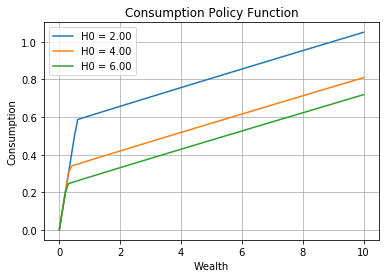

In [3]:
### Figure 1: See how different habit states change the consumption

# The habit parameters
Gamma = 0.8
Lambda = 0.5

# Run the model
dict_portfolio['PermGroFac'] = (gr_fac*(1-Lambda)).tolist()
agent = PortfolioConsumerType(**dict_portfolio)
agent.solve()


# Create a grid of market resources for the plots
    
mMin = 0    # Minimum ratio of assets to income to plot
mMax = 10 # Maximum ratio of assets to income to plot
mPts = 100 # Number of points to plot 

eevalgrid = np.linspace(0,mMax,mPts) # range of values of assets for the plot

### Habit
# Plot different habit states- Figure 1
plt.figure()
for H0 in [2,4,6]:
    
    H = np.ones(81)*H0
    H = H0**(Gamma)

    norm_factor = norm_factor_0/H

    # Ages
    ages = [25]
    age_born = time_params['Age_born']

    a = 25
    plt.plot(eevalgrid,
             agent.solution[a-age_born].cFuncAdj(eevalgrid/norm_factor[a-age_born])*norm_factor[a-age_born],
             label = 'H0 = {:.2f}'.format(H0))
plt.xlabel('Wealth')
plt.ylabel('Consumption')
plt.title('Consumption Policy Function')
plt.legend()
plt.grid()


if not in_ipynb():
    plt.show(block=False) 
    plt.pause(1)
else:
    plt.show(block=True)

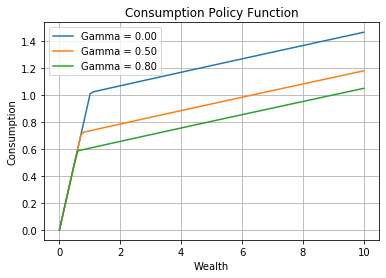

In [4]:
### Figure 2 and 4: See how Gamma change the consumption

plt.figure()
for Gamma in [0, 0.5, 0.8]:
    H0=2
    H = np.ones(81)*H0
    H = H0**(Gamma)

    norm_factor = norm_factor_0/H
    
    # In the last period of life you consume everything
    # so portfolio choice is irrelevant

    # Ages
    ages = [25]
    age_born = time_params['Age_born']

    a = 25
    plt.plot(eevalgrid,
             agent.solution[a-age_born].cFuncAdj(eevalgrid/norm_factor[a-age_born])*norm_factor[a-age_born],
             label = 'Gamma = {:.2f}'.format(Gamma))
plt.xlabel('Wealth')
plt.ylabel('Consumption')
plt.title('Consumption Policy Function')
plt.legend()
plt.grid()


if not in_ipynb():
    plt.show(block=False) 
    plt.pause(1)
else:
    plt.show(block=True)

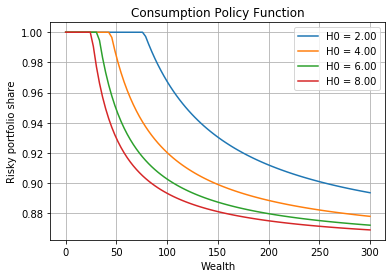

In [5]:
### Figure 3: See how different habit states change the wealth portfolio

# The habit parameters
Gamma = 0.8
Lambda = 0.5

# Run the model
dict_portfolio['PermGroFac'] = (gr_fac*(1-Lambda)).tolist()
agent = PortfolioConsumerType(**dict_portfolio)
agent.solve()

# Create a grid of market resources for the plots
    
mMin = 0    # Minimum ratio of assets to income to plot
mMax = 300 # Maximum ratio of assets to income to plot
mPts = 100 # Number of points to plot 

eevalgrid = np.linspace(0,mMax,mPts) # range of values of assets for the plot


# Plot share of wealth with different habit states- Figure 3
plt.figure()
for H0 in [2,4,6, 8]:

    H = np.ones(81)*H0
    H = H0**(Gamma)

    norm_factor = norm_factor_0/H

    
    # Ages
    ages = [25]
    age_born = time_params['Age_born']

    a = 25
    plt.plot(eevalgrid,
             agent.solution[a-age_born].ShareFuncAdj(eevalgrid/norm_factor[a-age_born]),
             label = 'H0 = {:.2f}'.format(H0))
plt.xlabel('Wealth')
plt.ylabel('Risky portfolio share')
plt.title('Consumption Policy Function')
plt.legend()
plt.grid()


if not in_ipynb():
    plt.show(block=False) 
    plt.pause(1)
else:
    plt.show(block=True)

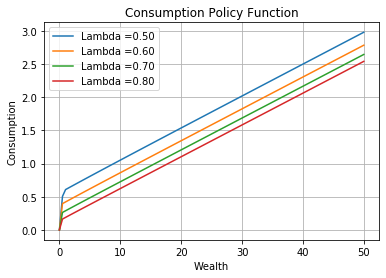

In [6]:
### Consumption function with different Lambda - page 739's description

Gamma = 0.8
H0=2
H = np.ones(82)*H0
H = H0**(Gamma)
    
norm_factor = norm_factor_0/H

mMin = 0    # Minimum ratio of assets to income to plot
mMax = 50 # Maximum ratio of assets to income to plot
mPts = 100 # Number of points to plot 

eevalgrid = np.linspace(0,mMax,mPts) # range of values of assets for the plot



plt.figure()
for Lambda in [0.5, 0.6, 0.7, 0.8]:

    # Run the model
    dict_portfolio['PermGroFac'] = (gr_fac*(1-Lambda)).tolist()
    agent = PortfolioConsumerType(**dict_portfolio)
    agent.solve()
    
    # Ages
    ages = [25]
    age_born = time_params['Age_born']

    a = 25
    plt.plot(eevalgrid,
             agent.solution[a-age_born].cFuncAdj(eevalgrid/norm_factor[a-age_born])*norm_factor[a-age_born],
             label = 'Lambda ={:.2f}'.format(Lambda))
plt.xlabel('Wealth')
plt.ylabel('Consumption')
plt.title('Consumption Policy Function')
plt.legend()
plt.grid()


if not in_ipynb():
    plt.show(block=False) 
    plt.pause(1)
else:
    plt.show(block=True)